[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/09_full_shift_adaptation.ipynb)


## 1. Setup - Mount Drive & Clone Repository

In [2]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository on main branch
print("Cloning repository (branch: main)...")
repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset locations (both clean and shifted)
CLEAN_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')
SHIFTED_DATASET_PATH = Path('/content/drive/MyDrive/mvtec_shifted')

# Output directories
MODELS_DIR = PROJECT_ROOT / 'outputs' / 'models'
RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'shifted_full_adaptation'

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify datasets exist
if not CLEAN_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Clean dataset not found at {CLEAN_DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive."
    )

if not SHIFTED_DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Shifted dataset not found at {SHIFTED_DATASET_PATH}\n"
        f"Please run notebook 03_domain_shift_generation.ipynb first."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

print("\n" + "="*70)
print("SETUP COMPLETE - PHASE 7: FULL SHIFT ADAPTATION")
print("="*70)
print(f"Project:  {PROJECT_ROOT}")
print(f"Clean Dataset:  {CLEAN_DATASET_PATH}")
print(f"Shifted Dataset: {SHIFTED_DATASET_PATH}")
print(f"Branch:   main")
print(f"Models:   {MODELS_DIR}")
print(f"Results:  {RESULTS_DIR}")
print(f"Thresholds: {THRESHOLDS_DIR}")
print(f"Viz:      {VIZ_DIR}")
print("="*70)

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done!

Cloning repository (branch: main)...
Removing existing repository...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 821 (delta 0), reused 1 (delta 0), pack-reused 798 (from 2)
Receiving objects: 100% (821/821), 312.75 MiB | 12.50 MiB/s, done.
Resolving deltas: 100% (457/457), done.
Updating files: 100% (105/105), done.
Done!


SETUP COMPLETE - PHASE 7: FULL SHIFT ADAPTATION
Project:  /content/Detection-of-Anomalies-with-Localization
Clean Dataset:  /content/drive/MyDrive/mvtec_ad
Shifted Dataset: /content/drive/MyDrive/mvtec_shifted
Branch:   main
Models:   /content/Detection-of-Anomalies-with-Localization/outputs/models
Results:  /content/Detection-of-Anomalie

## 2. Install Dependencies

In [3]:
# ============================================================
# INSTALL FAISS - MUST BE DONE BEFORE IMPORTS!
# ============================================================
# FAISS speeds up coreset sampling by 10-100x

!pip install faiss-cpu --quiet

# Verify installation
try:
    import faiss
    print("✓ FAISS installed successfully!")
    print(f"  FAISS version: {faiss.__version__}")
except ImportError:
    print("✗ FAISS installation failed, will use numpy fallback (VERY SLOW)")
    print("  Try running: !pip install faiss-cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.5 MB/s eta 0:00:00
✓ FAISS installed successfully!
  FAISS version: 1.13.1


In [4]:
# ============================================================
# INSTALL ANOMALIB - REQUIRED FOR PADIM
# ============================================================

print("Installing anomalib...")
!pip install anomalib --quiet

# Verify installation
try:
    import anomalib
    from anomalib.models.image.padim import Padim
    from anomalib.models.image.padim.torch_model import PadimModel
    print(f"✓ Success! anomalib {anomalib.__version__} installed")
    print("  PaDiM components available")
except ImportError as e:
    print(f"✗ Error: {e}")
    print("  Retry: !pip install anomalib")

Installing anomalib...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.8/241.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 15.2 MB/s eta 0:00:00
✓ Success! anomalib 2.2.0 installed
  PaDiM components available


## 3. Import Libraries

In [5]:

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import warnings
from tqdm import tqdm
from datetime import datetime

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_shift_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    calibrate_threshold_with_curve,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

from src.evaluation import Evaluator, MultiClassEvaluator

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to process
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("=" * 70)
print("PHASE 7: FULL SHIFT ADAPTATION")
print("=" * 70)
print(f"Using device: {DEVICE}")
print(f"Classes: {CLASSES}")
print(f"Coreset ratio: {config.patchcore.coreset_sampling_ratio}")
print(f"Batch size: 8")
print("=" * 70)

Random seed set to 42 for reproducibility
Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
PHASE 7: FULL SHIFT ADAPTATION
Using device: cpu
Classes: ['hazelnut', 'carpet', 'zipper']
Coreset ratio: 0.05
Batch size: 8


## 4. Load Shifted Splits

In [6]:
# Load shifted splits
SHIFTED_SPLITS_PATH = paths.get_split_path('shifted')
shifted_splits = load_splits(SHIFTED_SPLITS_PATH)

# Print split statistics
print("\nShifted Split Statistics:")
print("-" * 70)
for class_name in CLASSES:
    train_n = len(shifted_splits[class_name]['train']['images'])
    val_n = len(shifted_splits[class_name]['val']['images'])
    test_n = len(shifted_splits[class_name]['test']['images'])

    val_normal = sum(1 for l in shifted_splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in shifted_splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in shifted_splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in shifted_splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Train-shift: {train_n} (all normal)")
    print(f"  Val-shift: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test-shift: {test_n} ({test_normal} normal, {test_anom} anomalous)")
print("-" * 70)


Shifted Split Statistics:
----------------------------------------------------------------------
hazelnut:
  Train-shift: 312 (all normal)
  Val-shift: 100 (79 normal, 21 anomalous)
  Test-shift: 89 (40 normal, 49 anomalous)
carpet:
  Train-shift: 224 (all normal)
  Val-shift: 82 (56 normal, 26 anomalous)
  Test-shift: 91 (28 normal, 63 anomalous)
zipper:
  Train-shift: 192 (all normal)
  Val-shift: 83 (48 normal, 35 anomalous)
  Test-shift: 116 (32 normal, 84 anomalous)
----------------------------------------------------------------------


## 5. Prepare Data Transforms and Loaders

In [7]:
# Create transform for shifted data (same as clean - no additional augmentation)
# The domain shift is already "baked" into the shifted dataset images
transform = get_shift_transforms(
    image_size=config.dataset.image_size,
    normalize_mean=config.dataset.normalize.mean,
    normalize_std=config.dataset.normalize.std
)

print(f"[OK] Transform initialized:")
print(f"  Size: {config.dataset.image_size}x{config.dataset.image_size}")
print(f"  Normalization: ImageNet statistics")
print(f"  Note: Domain shift already applied in pre-generated shifted dataset")

# Custom collate function to handle None masks
def custom_collate_fn(batch):
    """Custom collate function that handles None masks."""
    images = torch.stack([item[0] for item in batch])
    masks = [item[1] for item in batch]  # Keep as list (may contain None)
    labels = torch.tensor([item[2] for item in batch])
    paths = [item[3] for item in batch]
    return images, masks, labels, paths

print("[OK] Custom collate function ready")

[OK] Transform initialized:
  Size: 224x224
  Normalization: ImageNet statistics
  Note: Domain shift already applied in pre-generated shifted dataset
[OK] Custom collate function ready


---
# PART A: PATCHCORE - FULL SHIFT ADAPTATION
---

## 6. Re-train PatchCore on Train-Shift

In [8]:
# Hyperparameters
CORESET_RATIO = config.patchcore.coreset_sampling_ratio
BATCH_SIZE = 8
NUM_WORKERS = 0  # Set to 0 for Colab

print("\n" + "="*70)
print("PATCHCORE - TRAINING ON TRAIN-SHIFT")
print("="*70)
print(f"Coreset ratio: {CORESET_RATIO*100:.1f}%")
print(f"Batch size: {BATCH_SIZE}")
print(f"Num workers: {NUM_WORKERS}")
print(f"Image size: {config.dataset.image_size}")
print(f"Backbone layers: {config.patchcore.layers}")
print(f"Patch size: {config.patchcore.patch_size}")
print(f"N neighbors: {config.patchcore.n_neighbors}")
print("="*70)


PATCHCORE - TRAINING ON TRAIN-SHIFT
Coreset ratio: 5.0%
Batch size: 8
Num workers: 0
Image size: 224
Backbone layers: ['layer2', 'layer3']
Patch size: 3
N neighbors: 9


In [9]:

# Train PatchCore models on shifted data
patchcore_models_shift = {}
patchcore_training_stats_shift = {}

for class_name in CLASSES:
    print("\n" + "=" * 70)
    print(f"Training PatchCore on TRAIN-SHIFT: {class_name.upper()}")
    print("=" * 70)

    # Check if model files already exist
    model_file = paths.MODELS / f'patchcore_{class_name}_shift.npy'
    config_file = paths.MODELS / f'patchcore_{class_name}_shift_config.pth'

    if model_file.exists() and config_file.exists():
        print(f"\n✓ Model files found! Loading existing model...")
        print(f"  • {model_file.name}")
        print(f"  • {config_file.name}")

        # Load existing model
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )
        model.load(paths.MODELS, class_name, domain='shift')

        # Load training stats from config file
        checkpoint = torch.load(config_file, map_location=DEVICE)
        patchcore_training_stats_shift[class_name] = {
            'n_train_images': checkpoint.get('n_train_images', 'N/A'),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': checkpoint.get('training_time_seconds', 'N/A'),
            'spatial_dims': model.spatial_dims
        }

        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Spatial dims: {model.spatial_dims}")
        print("  [SKIPPED TRAINING - Using cached model]")

    else:
        print(f"\n⚠ Model files not found. Starting training from scratch...")

        # Create train dataset (only normal images from shifted data)
        train_split = shifted_splits[class_name]['train']
        train_dataset = MVTecDataset.from_split(
            train_split,
            transform=transform,
            phase='train'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
            collate_fn=custom_collate_fn
        )

        print(f"\nTrain-shift dataset: {len(train_dataset)} images")

        # Initialize PatchCore
        model = PatchCore(
            backbone_layers=config.patchcore.layers,
            patch_size=config.patchcore.patch_size,
            coreset_ratio=CORESET_RATIO,
            n_neighbors=config.patchcore.n_neighbors,
            device=DEVICE
        )

        # Fit model
        start_time = time.time()
        model.fit(train_loader, apply_coreset=True)
        training_time = time.time() - start_time

        # Save model with 'shift' domain tag
        model.save(paths.MODELS, class_name, domain='shift')

        # Store statistics
        patchcore_training_stats_shift[class_name] = {
            'n_train_images': len(train_dataset),
            'memory_bank_size': len(model.memory_bank),
            'training_time_seconds': training_time,
            'spatial_dims': model.spatial_dims
        }

        print(f"\nCompleted {class_name.upper()}:")
        print(f"  Memory bank size: {len(model.memory_bank)}")
        print(f"  Training time: {training_time:.2f}s")
        print(f"  Spatial dims: {model.spatial_dims}")

    # Store model in dictionary
    patchcore_models_shift[class_name] = model

print("\n" + "=" * 70)
print("✓ All PatchCore models ready!")
print("=" * 70)


Training PatchCore on TRAIN-SHIFT: HAZELNUT

✓ Model files found! Loading existing model...
  • patchcore_hazelnut_shift.npy
  • patchcore_hazelnut_shift_config.pth
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


✓ Using FAISS for fast k-NN search (memory bank: 12230 samples, 1536 dims)
  Memory bank size: 12230
  Spatial dims: (28, 28)
  [SKIPPED TRAINING - Using cached model]

Training PatchCore on TRAIN-SHIFT: CARPET

✓ Model files found! Loading existing model...
  • patchcore_carpet_shift.npy
  • patchcore_carpet_shift_config.pth
✓ Using FAISS for fast k-NN search (memory bank: 8780 samples, 1536 dims)
  Memory bank size: 8780
  Spatial dims: (28, 28)
  [SKIPPED TRAINING - Using cached model]

Training PatchCore on TRAIN-SHIFT: ZIPPER

✓ Model files found! Loading existing model...
  • patchcore_zipper_shift.npy
  • patchcore_zipper_shift_config.pth
✓ Using FAISS for fast k-NN search (memory bank: 7526 samples, 1536 dims)
  Memory bank size: 7526
  Spatial dims: (28, 28)
  [SKIPPED TRAINING - Using cached model]

✓ All PatchCore models ready!


## 7. PatchCore - Predict on Val-Shift for Threshold Calibration

In [10]:
print("\n" + "="*70)
print("PATCHCORE - PREDICTING ON VAL-SHIFT")
print("="*70)

patchcore_val_predictions_shift = {}

for class_name in CLASSES:
    print(f"\nProcessing {class_name.upper()}...")

    model = patchcore_models_shift[class_name]

    # Load val-shift data
    val_split = shifted_splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f"Val-shift {class_name}"):
            images = images.to(DEVICE)
            scores, _ = model.predict(images, return_heatmaps=True)
            # Fix: Remove .numpy() as scores is already a numpy array after model.predict()
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())

    patchcore_val_predictions_shift[class_name] = {
        'scores': all_scores,
        'labels': all_labels
    }

    print(f"  Val-shift predictions: {len(all_scores)} samples")
    print(f"  Normal: {sum(1 for l in all_labels if l == 0)}, Anomalous: {sum(1 for l in all_labels if l == 1)}")

print("\n✓ PatchCore val-shift predictions complete!")


PATCHCORE - PREDICTING ON VAL-SHIFT

Processing HAZELNUT...


Val-shift hazelnut: 100%|██████████| 13/13 [02:59<00:00, 13.78s/it]


  Val-shift predictions: 100 samples
  Normal: 79, Anomalous: 21

Processing CARPET...


Val-shift carpet: 100%|██████████| 11/11 [02:27<00:00, 13.42s/it]


  Val-shift predictions: 82 samples
  Normal: 56, Anomalous: 26

Processing ZIPPER...


Val-shift zipper: 100%|██████████| 11/11 [02:35<00:00, 14.12s/it]

  Val-shift predictions: 83 samples
  Normal: 48, Anomalous: 35

✓ PatchCore val-shift predictions complete!


## 8. PatchCore - Calibrate Thresholds on Val-Shift

In [13]:
print("\n" + "="*70)
print("PATCHCORE - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)")
print("="*70)

patchcore_thresholds_path = THRESHOLDS_DIR / 'patchcore_shift_thresholds.json'

# Check if thresholds already exist
if patchcore_thresholds_path.exists():
    print(f"\n✓ Threshold file found! Loading existing thresholds...")
    print(f"  • {patchcore_thresholds_path.name}")

    # Load raw JSON to inspect
    with open(patchcore_thresholds_path, 'r') as f:
        threshold_data = json.load(f)

    # Check if thresholds dict exists and has data
    if 'thresholds' in threshold_data and len(threshold_data['thresholds']) > 0:
        patchcore_calibrator_shift = ThresholdCalibrator('patchcore_shift')

        # Map class names (case-insensitive)
        saved_thresholds = threshold_data['thresholds']

        # Try to match class names
        for class_name in CLASSES:
            # Try exact match first
            if class_name in saved_thresholds:
                patchcore_calibrator_shift.thresholds[class_name] = saved_thresholds[class_name]
            # Try case-insensitive match
            elif class_name.lower() in [k.lower() for k in saved_thresholds.keys()]:
                matching_key = [k for k in saved_thresholds.keys() if k.lower() == class_name.lower()][0]
                patchcore_calibrator_shift.thresholds[class_name] = saved_thresholds[matching_key]
                print(f"  ⚠ Remapped '{matching_key}' → '{class_name}'")
            else:
                print(f"  ✗ Missing threshold for '{class_name}', will recalibrate")
                # Recalibrate this class
                scores = np.array(patchcore_val_predictions_shift[class_name]['scores'])
                labels = np.array(patchcore_val_predictions_shift[class_name]['labels'])
                threshold = patchcore_calibrator_shift.calibrate(class_name, scores, labels)
                print(f"    → New threshold: {threshold:.4f}")

        print("\nLoaded thresholds:")
        for class_name in CLASSES:
            threshold = patchcore_calibrator_shift.get_threshold(class_name)
            print(f"  {class_name}: {threshold:.4f}")

        # Re-save with correct keys
        patchcore_calibrator_shift.save(patchcore_thresholds_path)
        print(f"  [Thresholds normalized and saved]")
    else:
        print(f"\n⚠ Threshold file is empty or invalid, recalibrating...")
        raise ValueError("Empty thresholds, skip to else block")

else:
    print(f"\n⚠ Threshold file not found. Starting calibration from scratch...")

    patchcore_calibrator_shift = ThresholdCalibrator('patchcore_shift')

    for class_name in CLASSES:
        print(f"\n{class_name.upper()}:")

        scores = np.array(patchcore_val_predictions_shift[class_name]['scores'])
        labels = np.array(patchcore_val_predictions_shift[class_name]['labels'])

        threshold = patchcore_calibrator_shift.calibrate(class_name, scores, labels)

        print(f"  Optimal threshold: {threshold:.4f}")
        print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

    # Save thresholds
    patchcore_calibrator_shift.save(patchcore_thresholds_path)
    print(f"\n✓ PatchCore thresholds saved to: {patchcore_thresholds_path}")


PATCHCORE - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)

✓ Threshold file found! Loading existing thresholds...
  • patchcore_shift_thresholds.json

Loaded thresholds:
  hazelnut: 425.5469
  carpet: 241.7909
  zipper: 221.6002
[OK] Thresholds saved: patchcore_shift_thresholds.json
  [Thresholds normalized and saved]


## 9. PatchCore - Evaluate on Test-Shift

In [17]:


print("\n" + "="*70)
print("PATCHCORE - EVALUATION ON TEST-SHIFT")
print("="*70)

patchcore_results_shift = {}

for class_name in CLASSES:
    print(f"\n{'='*70}")
    print(f"Evaluating {class_name.upper()}")
    print(f"{'='*70}")

    model = patchcore_models_shift[class_name]
    threshold = patchcore_calibrator_shift.get_threshold(class_name)

    # Load test-shift data
    test_split = shifted_splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_heatmaps = []
    all_labels = []
    all_masks = []
    all_paths = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f"Test-shift {class_name}"):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_heatmaps.extend(heatmaps.tolist())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks)
            all_paths.extend(paths)

    all_scores = np.array(all_scores)
    all_heatmaps = np.array(all_heatmaps)
    all_labels = np.array(all_labels)

    # Image-level metrics
    image_metrics = compute_image_metrics(
        all_labels,
        all_scores,
        threshold=threshold
    )

    # Pixel-level metrics (only for anomalous images with masks)
    pixel_metrics = None
    anomalous_indices = [i for i, l in enumerate(all_labels) if l == 1]
    if len(anomalous_indices) > 0:
        masks_true = []
        heatmaps_pred = []

        for i in anomalous_indices:
            mask = all_masks[i]
            if mask is not None:
                # FIX: Convert to numpy and squeeze to remove channel dimension
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().squeeze()  # (1, H, W) → (H, W)
                else:
                    mask_np = np.array(mask).squeeze()

                masks_true.append(mask_np)
                heatmaps_pred.append(all_heatmaps[i])

        if len(masks_true) > 0:
            pixel_metrics = compute_pixel_metrics(masks_true, heatmaps_pred)

    patchcore_results_shift[class_name] = {
        'image_metrics': image_metrics,
        'pixel_metrics': pixel_metrics,
        'threshold': threshold,
        'n_test_samples': len(all_labels),
        'n_anomalous': sum(all_labels),
        'predictions': {
            'scores': all_scores.tolist(),
            'labels': all_labels.tolist(),
            'paths': all_paths
        }
    }

    print(f"\n{class_name.upper()} - Results:")
    print(f"  Image AUROC: {image_metrics['auroc']:.4f}")
    print(f"  Image AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1-Score: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics['accuracy']:.4f}")
    if pixel_metrics:
        if pixel_metrics['pixel_auroc'] is not None:
            print(f"  Pixel AUROC: {pixel_metrics['pixel_auroc']:.4f}")
        else:
            print(f"  Pixel AUROC: Not Computed (Mask/Heatmap shape mismatch)")
        print(f"  PRO-Score: {pixel_metrics['pro']:.4f}")

print("\n" + "=" * 70)
print("✓ PatchCore evaluation on TEST-SHIFT complete!")
print("=" * 70)


PATCHCORE - EVALUATION ON TEST-SHIFT

Evaluating HAZELNUT


Test-shift hazelnut: 100%|██████████| 12/12 [01:09<00:00,  5.81s/it]



HAZELNUT - Results:
  Image AUROC: 0.9602
  Image AUPRC: 0.9771
  F1-Score: 0.9167
  Accuracy: 0.9101
  Pixel AUROC: 0.9633
  PRO-Score: 0.7374

Evaluating CARPET


Test-shift carpet: 100%|██████████| 12/12 [01:28<00:00,  7.41s/it]



CARPET - Results:
  Image AUROC: 0.8679
  Image AUPRC: 0.9475
  F1-Score: 0.8036
  Accuracy: 0.7582
  Pixel AUROC: 0.9312
  PRO-Score: 0.6251

Evaluating ZIPPER


Test-shift zipper: 100%|██████████| 15/15 [03:58<00:00, 15.92s/it]



ZIPPER - Results:
  Image AUROC: 0.8251
  Image AUPRC: 0.9230
  F1-Score: 0.8050
  Accuracy: 0.7328
  Pixel AUROC: 0.9113
  PRO-Score: 0.5566

✓ PatchCore evaluation on TEST-SHIFT complete!


## 10. Save PatchCore Results

In [22]:


import numpy as np

def convert_numpy_types(obj):
    """Recursively convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare results summary
patchcore_summary_shift = {
    'method': 'PatchCore',
    'domain': 'shift',
    'adaptation': 'full',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'coreset_ratio': float(CORESET_RATIO),  # Convert to native Python float
        'backbone_layers': config.patchcore.layers,
        'n_neighbors': int(config.patchcore.n_neighbors)  # Convert to native Python int
    },
    'training_statistics': convert_numpy_types(patchcore_training_stats_shift),
    'validation_predictions': convert_numpy_types(patchcore_val_predictions_shift),
    'test_results': convert_numpy_types(patchcore_results_shift)
}

# Save to JSON
patchcore_results_path = RESULTS_DIR / 'patchcore_shift_full_adaptation_results.json'
with open(patchcore_results_path, 'w') as f:
    json.dump(patchcore_summary_shift, f, indent=2)

print(f"✓ PatchCore results saved to: {patchcore_results_path}")

# Save training stats as CSV
import pandas as pd
patchcore_stats_df = pd.DataFrame(patchcore_training_stats_shift).T
patchcore_stats_df['training_time_seconds'] = patchcore_stats_df['training_time_seconds'].apply(
    lambda x: f"{float(x):.2f}" if isinstance(x, (int, float, np.number)) else x
)
patchcore_stats_csv = RESULTS_DIR / 'patchcore_shift_training_stats.csv'
patchcore_stats_df.to_csv(patchcore_stats_csv)
print(f"✓ Training stats saved to: {patchcore_stats_csv}")

✓ PatchCore results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_full_adaptation_results.json
✓ Training stats saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/patchcore_shift_training_stats.csv


---
# PART B: PADIM - FULL SHIFT ADAPTATION
---

## 11. Re-train PaDiM on Train-Shift

In [23]:
print("\n" + "="*70)
print("PADIM - TRAINING ON TRAIN-SHIFT")
print("="*70)
print(f"Backbone: {config.padim.backbone}")
print(f"Layers: {config.padim.layers}")
print(f"N features: {config.padim.n_features}")
print(f"Batch size: {BATCH_SIZE}")
print("="*70)


PADIM - TRAINING ON TRAIN-SHIFT
Backbone: resnet50
Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Batch size: 8


In [24]:

# Train PaDiM models on shifted data
padim_models_shift = {}
padim_training_stats_shift = {}

for class_name in CLASSES:
    print("\n" + "=" * 70)
    print(f"Training PaDiM on TRAIN-SHIFT: {class_name.upper()}")
    print("=" * 70)

    # Check if model file already exists
    model_path = MODELS_DIR / f"padim_{class_name}_shift.pt"

    if model_path.exists():
        print(f"\n✓ Model file found! Loading existing model...")
        print(f"  • {model_path.name}")

        # Load existing model
        model = PadimWrapper(
            backbone=config.padim.backbone,
            layers=config.padim.layers,
            n_features=config.padim.n_features,
            image_size=config.dataset.image_size,
            device=DEVICE
        )
        model.load(model_path)

        # Extract training stats from loaded model
        padim_training_stats_shift[class_name] = {
            'n_train_images': model.training_stats.get('num_samples', 'N/A'),
            'training_time_seconds': model.training_stats.get('training_time_seconds', 'N/A'),
            'memory_bank_size_mb': model.training_stats.get('memory_bank_size_mb', 'N/A')
        }

        print(f"  Training samples: {model.training_stats.get('num_samples', 'N/A')}")
        print(f"  Training time: {model.training_stats.get('training_time_seconds', 'N/A'):.2f}s")
        print("  [SKIPPED TRAINING - Using cached model]")

    else:
        print(f"\n⚠ Model file not found. Starting training from scratch...")

        # Create train dataset
        train_split = shifted_splits[class_name]['train']
        train_dataset = MVTecDataset.from_split(
            train_split,
            transform=transform,
            phase='train'
        )

        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=False,
            collate_fn=custom_collate_fn
        )

        print(f"\nTrain-shift dataset: {len(train_dataset)} images")

        # Initialize PaDiM
        model = PadimWrapper(
            backbone=config.padim.backbone,
            layers=config.padim.layers,
            n_features=config.padim.n_features,
            image_size=config.dataset.image_size,
            device=DEVICE
        )

        # Train (fit on normal samples)
        model.fit(train_loader, verbose=True)

        # Save model with 'shift' domain tag
        model.save(model_path, include_stats=True)

        # Store statistics
        padim_training_stats_shift[class_name] = {
            'n_train_images': model.training_stats['num_samples'],
            'training_time_seconds': model.training_stats['training_time_seconds'],
            'memory_bank_size_mb': model.training_stats['memory_bank_size_mb']
        }

        print(f"\nCompleted {class_name.upper()}:")
        print(f"  Model: {model_path.name}")
        print(f"  Training time: {model.training_stats['training_time_seconds']:.2f}s")

    # Store model in dictionary
    padim_models_shift[class_name] = model

print("\n" + "=" * 70)
print("✓ All PaDiM models ready!")
print("=" * 70)


Training PaDiM on TRAIN-SHIFT: HAZELNUT

⚠ Model file not found. Starting training from scratch...

Train-shift dataset: 312 images


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Training PaDiM on 312 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cpu



Extracting features: 100%|██████████| 39/39 [06:03<00:00,  9.32s/it]



Fitting Gaussian distributions...
  Total samples: 312
  Memory bank size: 39 batches

[OK] Training completed in 373.26s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_hazelnut_shift.pt
  Stats saved: padim_hazelnut_shift.json

Completed HAZELNUT:
  Model: padim_hazelnut_shift.pt
  Training time: 373.26s

Training PaDiM on TRAIN-SHIFT: CARPET

⚠ Model file not found. Starting training from scratch...

Train-shift dataset: 224 images

Training PaDiM on 224 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cpu



Extracting features: 100%|██████████| 28/28 [04:25<00:00,  9.47s/it]



Fitting Gaussian distributions...
  Total samples: 224
  Memory bank size: 28 batches

[OK] Training completed in 273.63s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_carpet_shift.pt
  Stats saved: padim_carpet_shift.json

Completed CARPET:
  Model: padim_carpet_shift.pt
  Training time: 273.63s

Training PaDiM on TRAIN-SHIFT: ZIPPER

⚠ Model file not found. Starting training from scratch...

Train-shift dataset: 192 images

Training PaDiM on 192 normal samples
Backbone: resnet50 | Layers: ['layer1', 'layer2', 'layer3']
N features: 100
Device: cpu



Extracting features: 100%|██████████| 24/24 [03:40<00:00,  9.20s/it]



Fitting Gaussian distributions...
  Total samples: 192
  Memory bank size: 24 batches

[OK] Training completed in 227.08s
  Gaussian mean shape: torch.Size([100, 3136])
  Inv covariance shape: torch.Size([3136, 100, 100])
  Memory usage: 120.83 MB

[OK] Model saved: padim_zipper_shift.pt
  Stats saved: padim_zipper_shift.json

Completed ZIPPER:
  Model: padim_zipper_shift.pt
  Training time: 227.08s

✓ All PaDiM models ready!


## 12. PaDiM - Predict on Val-Shift for Threshold Calibration

In [27]:
print("\n" + "="*70)
print("PADIM - PREDICTING ON VAL-SHIFT")
print("="*70)

padim_val_predictions_shift = {}

for class_name in CLASSES:
    print(f"\nProcessing {class_name.upper()}...")

    model = padim_models_shift[class_name]

    # Load val-shift data
    val_split = shifted_splits[class_name]['val']
    val_dataset = MVTecDataset.from_split(
        val_split,
        transform=transform,
        phase='val'
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(val_loader, desc=f"Val-shift {class_name}"):
            images = images.to(DEVICE)
            scores, _ = model.predict(images)
            # Fix: scores is already a numpy array, no need to call .numpy() again
            all_scores.extend(scores)
            all_labels.extend(labels.numpy())

    padim_val_predictions_shift[class_name] = {
        'scores': all_scores,
        'labels': all_labels
    }

    print(f"  Val-shift predictions: {len(all_scores)} samples")
    print(f"  Normal: {sum(1 for l in all_labels if l == 0)}, Anomalous: {sum(1 for l in all_labels if l == 1)}")

print("\n✓ PaDiM val-shift predictions complete!")


PADIM - PREDICTING ON VAL-SHIFT

Processing HAZELNUT...


Val-shift hazelnut: 100%|██████████| 13/13 [00:33<00:00,  2.59s/it]


  Val-shift predictions: 100 samples
  Normal: 79, Anomalous: 21

Processing CARPET...


Val-shift carpet: 100%|██████████| 11/11 [00:28<00:00,  2.56s/it]


  Val-shift predictions: 82 samples
  Normal: 56, Anomalous: 26

Processing ZIPPER...


Val-shift zipper: 100%|██████████| 11/11 [00:29<00:00,  2.65s/it]

  Val-shift predictions: 83 samples
  Normal: 48, Anomalous: 35

✓ PaDiM val-shift predictions complete!


## 13. PaDiM - Calibrate Thresholds on Val-Shift

In [28]:
print("\n" + "="*70)
print("PADIM - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)")
print("="*70)

padim_calibrator_shift = ThresholdCalibrator('padim_shift')

for class_name in CLASSES:
    print(f"\n{class_name.upper()}:")

    scores = np.array(padim_val_predictions_shift[class_name]['scores'])
    labels = np.array(padim_val_predictions_shift[class_name]['labels'])

    threshold = padim_calibrator_shift.calibrate(class_name, scores, labels)

    print(f"  Optimal threshold: {threshold:.4f}")
    print(f"  Score range: [{scores.min():.4f}, {scores.max():.4f}]")

# Save thresholds
padim_thresholds_path = THRESHOLDS_DIR / 'padim_shift_thresholds.json'
padim_calibrator_shift.save(padim_thresholds_path)
print(f"\n✓ PaDiM thresholds saved to: {padim_thresholds_path}")


PADIM - THRESHOLD CALIBRATION (F1-Optimal on Val-Shift)

HAZELNUT:
  Optimal threshold: 44.1664
  Score range: [14.8399, 129.6363]

CARPET:
  Optimal threshold: 26.4804
  Score range: [13.0602, 113.2375]

ZIPPER:
  Optimal threshold: 20.9470
  Score range: [14.3498, 160.5143]
[OK] Thresholds saved: padim_shift_thresholds.json

✓ PaDiM thresholds saved to: /content/Detection-of-Anomalies-with-Localization/outputs/thresholds/padim_shift_thresholds.json


## 14. PaDiM - Evaluate on Test-Shift

In [31]:


print("\n" + "="*70)
print("PADIM - EVALUATION ON TEST-SHIFT")
print("="*70)

padim_results_shift = {}

for class_name in CLASSES:
    print(f"\n{'='*70}")
    print(f"Evaluating {class_name.upper()}")
    print(f"{'='*70}")

    model = padim_models_shift[class_name]
    threshold = padim_calibrator_shift.get_threshold(class_name)

    # Load test-shift data
    test_split = shifted_splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=False,
        collate_fn=custom_collate_fn
    )

    # Predict
    all_scores = []
    all_heatmaps = []
    all_labels = []
    all_masks = []
    all_paths = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f"Test-shift {class_name}"):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images)

            # FIX: Remove .cpu() as scores and heatmaps are already numpy arrays
            all_scores.extend(scores.tolist())
            all_heatmaps.extend(heatmaps.tolist())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks)
            all_paths.extend(paths)

    all_scores = np.array(all_scores)
    all_heatmaps = np.array(all_heatmaps)
    all_labels = np.array(all_labels)

    # Image-level metrics
    image_metrics = compute_image_metrics(
        all_labels,
        all_scores,
        threshold=threshold
    )

    # Pixel-level metrics
    pixel_metrics = None
    anomalous_indices = [i for i, l in enumerate(all_labels) if l == 1]
    if len(anomalous_indices) > 0:
        masks_true = []
        heatmaps_pred = []

        for i in anomalous_indices:
            mask = all_masks[i]
            if mask is not None:
                # FIX: Convert to numpy and squeeze to remove channel dimension
                if isinstance(mask, torch.Tensor):
                    mask_np = mask.cpu().numpy().squeeze()  # (1, H, W) → (H, W)
                else:
                    mask_np = np.array(mask).squeeze()

                masks_true.append(mask_np)
                heatmaps_pred.append(all_heatmaps[i])

        if len(masks_true) > 0:
            pixel_metrics = compute_pixel_metrics(masks_true, heatmaps_pred)

    padim_results_shift[class_name] = {
        'image_metrics': image_metrics,
        'pixel_metrics': pixel_metrics,
        'threshold': threshold,
        'n_test_samples': len(all_labels),
        'n_anomalous': sum(all_labels),
        'predictions': {
            'scores': all_scores.tolist(),
            'labels': all_labels.tolist(),
            'paths': all_paths
        }
    }

    print(f"\n{class_name.upper()} - Results:")
    print(f"  Image AUROC: {image_metrics['auroc']:.4f}")
    print(f"  Image AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1-Score: {image_metrics['f1']:.4f}")
    print(f"  Accuracy: {image_metrics['accuracy']:.4f}")
    if pixel_metrics:
        print(f"  Pixel AUROC: {pixel_metrics['pixel_auroc']:.4f}")
        print(f"  PRO-Score: {pixel_metrics['pro']:.4f}") # FIX: Changed 'pro_score' to 'pro'

print("\n" + "=" * 70)
print("\u2713 PaDiM evaluation on TEST-SHIFT complete!")
print("=" * 70)


PADIM - EVALUATION ON TEST-SHIFT

Evaluating HAZELNUT


Test-shift hazelnut: 100%|██████████| 12/12 [00:30<00:00,  2.58s/it]



HAZELNUT - Results:
  Image AUROC: 0.7332
  Image AUPRC: 0.7194
  F1-Score: 0.4507
  Accuracy: 0.5618
  Pixel AUROC: 0.9253
  PRO-Score: 0.5841

Evaluating CARPET


Test-shift carpet: 100%|██████████| 12/12 [00:31<00:00,  2.65s/it]



CARPET - Results:
  Image AUROC: 0.7942
  Image AUPRC: 0.9066
  F1-Score: 0.7934
  Accuracy: 0.7253
  Pixel AUROC: 0.9184
  PRO-Score: 0.7276

Evaluating ZIPPER


Test-shift zipper: 100%|██████████| 15/15 [00:41<00:00,  2.77s/it]



ZIPPER - Results:
  Image AUROC: 0.6789
  Image AUPRC: 0.8544
  F1-Score: 0.8191
  Accuracy: 0.7069
  Pixel AUROC: 0.8269
  PRO-Score: 0.5166

✓ PaDiM evaluation on TEST-SHIFT complete!


## 15. Save PaDiM Results

In [32]:


# Prepare results summary (riusa la funzione convert_numpy_types già definita)
padim_summary_shift = {
    'method': 'PaDiM',
    'domain': 'shift',
    'adaptation': 'full',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'backbone': config.padim.backbone,
        'layers': config.padim.layers,
        'n_features': int(config.padim.n_features)  # Convert to native Python int
    },
    'training_statistics': convert_numpy_types(padim_training_stats_shift),
    'validation_predictions': convert_numpy_types(padim_val_predictions_shift),
    'test_results': convert_numpy_types(padim_results_shift)
}

# Save to JSON
padim_results_path = RESULTS_DIR / 'padim_shift_full_adaptation_results.json'
with open(padim_results_path, 'w') as f:
    json.dump(padim_summary_shift, f, indent=2)

print(f"✓ PaDiM results saved to: {padim_results_path}")

# Save training stats as CSV
padim_stats_df = pd.DataFrame(padim_training_stats_shift).T
padim_stats_df['training_time_seconds'] = padim_stats_df['training_time_seconds'].apply(
    lambda x: f"{float(x):.2f}" if isinstance(x, (int, float, np.number)) else x
)
padim_stats_csv = RESULTS_DIR / 'padim_shift_training_stats.csv'
padim_stats_df.to_csv(padim_stats_csv)
print(f"✓ Training stats saved to: {padim_stats_csv}")

✓ PaDiM results saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/padim_shift_full_adaptation_results.json
✓ Training stats saved to: /content/Detection-of-Anomalies-with-Localization/outputs/results/padim_shift_training_stats.csv


---
# PART C: AGGREGATE RESULTS & VISUALIZATIONS
---

## 16. Aggregate Results Summary

In [33]:
print("\n" + "="*70)
print("AGGREGATE RESULTS - PHASE 7: FULL SHIFT ADAPTATION")
print("="*70)

# Aggregate image-level metrics
def aggregate_image_metrics_across_classes(results_dict):
    """Aggregate image-level metrics across all classes."""
    metrics_by_class = {}
    for class_name, result in results_dict.items():
        metrics_by_class[class_name] = result['image_metrics']

    # Compute macro-average
    macro_avg = {}
    for metric in ['auroc', 'auprc', 'f1', 'accuracy', 'precision', 'recall']:
        values = [m[metric] for m in metrics_by_class.values()]
        macro_avg[metric] = np.mean(values)

    return metrics_by_class, macro_avg

# PatchCore
pc_metrics_by_class, pc_macro = aggregate_image_metrics_across_classes(patchcore_results_shift)

# PaDiM
pd_metrics_by_class, pd_macro = aggregate_image_metrics_across_classes(padim_results_shift)

# Print summary table
print("\n" + "-"*70)
print("IMAGE-LEVEL METRICS (Test-Shift with Full Adaptation)")
print("-"*70)
print(f"{'Class':<12} {'Method':<10} {'AUROC':>8} {'AUPRC':>8} {'F1':>8} {'Acc':>8}")
print("-"*70)

for class_name in CLASSES:
    pc_m = pc_metrics_by_class[class_name]
    pd_m = pd_metrics_by_class[class_name]

    print(f"{class_name:<12} {'PatchCore':<10} {pc_m['auroc']:>8.4f} {pc_m['auprc']:>8.4f} {pc_m['f1']:>8.4f} {pc_m['accuracy']:>8.4f}")
    print(f"{'':<12} {'PaDiM':<10} {pd_m['auroc']:>8.4f} {pd_m['auprc']:>8.4f} {pd_m['f1']:>8.4f} {pd_m['accuracy']:>8.4f}")
    print("-"*70)

print(f"{'MACRO AVG':<12} {'PatchCore':<10} {pc_macro['auroc']:>8.4f} {pc_macro['auprc']:>8.4f} {pc_macro['f1']:>8.4f} {pc_macro['accuracy']:>8.4f}")
print(f"{'':<12} {'PaDiM':<10} {pd_macro['auroc']:>8.4f} {pd_macro['auprc']:>8.4f} {pd_macro['f1']:>8.4f} {pd_macro['accuracy']:>8.4f}")
print("="*70)

# Save summary CSV
summary_data = []
for class_name in CLASSES:
    pc_m = pc_metrics_by_class[class_name]
    pd_m = pd_metrics_by_class[class_name]

    summary_data.append({
        'class': class_name,
        'method': 'PatchCore',
        'domain': 'shift',
        'adaptation': 'full',
        'auroc': pc_m['auroc'],
        'auprc': pc_m['auprc'],
        'f1': pc_m['f1'],
        'accuracy': pc_m['accuracy'],
        'precision': pc_m['precision'],
        'recall': pc_m['recall']
    })

    summary_data.append({
        'class': class_name,
        'method': 'PaDiM',
        'domain': 'shift',
        'adaptation': 'full',
        'auroc': pd_m['auroc'],
        'auprc': pd_m['auprc'],
        'f1': pd_m['f1'],
        'accuracy': pd_m['accuracy'],
        'precision': pd_m['precision'],
        'recall': pd_m['recall']
    })

# Add macro averages
summary_data.append({
    'class': 'MACRO_AVG',
    'method': 'PatchCore',
    'domain': 'shift',
    'adaptation': 'full',
    'auroc': pc_macro['auroc'],
    'auprc': pc_macro['auprc'],
    'f1': pc_macro['f1'],
    'accuracy': pc_macro['accuracy'],
    'precision': pc_macro['precision'],
    'recall': pc_macro['recall']
})

summary_data.append({
    'class': 'MACRO_AVG',
    'method': 'PaDiM',
    'domain': 'shift',
    'adaptation': 'full',
    'auroc': pd_macro['auroc'],
    'auprc': pd_macro['auprc'],
    'f1': pd_macro['f1'],
    'accuracy': pd_macro['accuracy'],
    'precision': pd_macro['precision'],
    'recall': pd_macro['recall']
})

summary_df = pd.DataFrame(summary_data)
summary_csv_path = RESULTS_DIR / 'shift_full_adaptation_results_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"\n✓ Summary CSV saved to: {summary_csv_path}")


AGGREGATE RESULTS - PHASE 7: FULL SHIFT ADAPTATION

----------------------------------------------------------------------
IMAGE-LEVEL METRICS (Test-Shift with Full Adaptation)
----------------------------------------------------------------------
Class        Method        AUROC    AUPRC       F1      Acc
----------------------------------------------------------------------
hazelnut     PatchCore    0.9602   0.9771   0.9167   0.9101
             PaDiM        0.7332   0.7194   0.4507   0.5618
----------------------------------------------------------------------
carpet       PatchCore    0.8679   0.9475   0.8036   0.7582
             PaDiM        0.7942   0.9066   0.7934   0.7253
----------------------------------------------------------------------
zipper       PatchCore    0.8251   0.9230   0.8050   0.7328
             PaDiM        0.6789   0.8544   0.8191   0.7069
----------------------------------------------------------------------
MACRO AVG    PatchCore    0.8844   0.9492   0.8


SCORE DISTRIBUTIONS & CALIBRATED THRESHOLDS (Val-shift)

[SAVED] /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/score_distributions_shift_full_adaptation.png


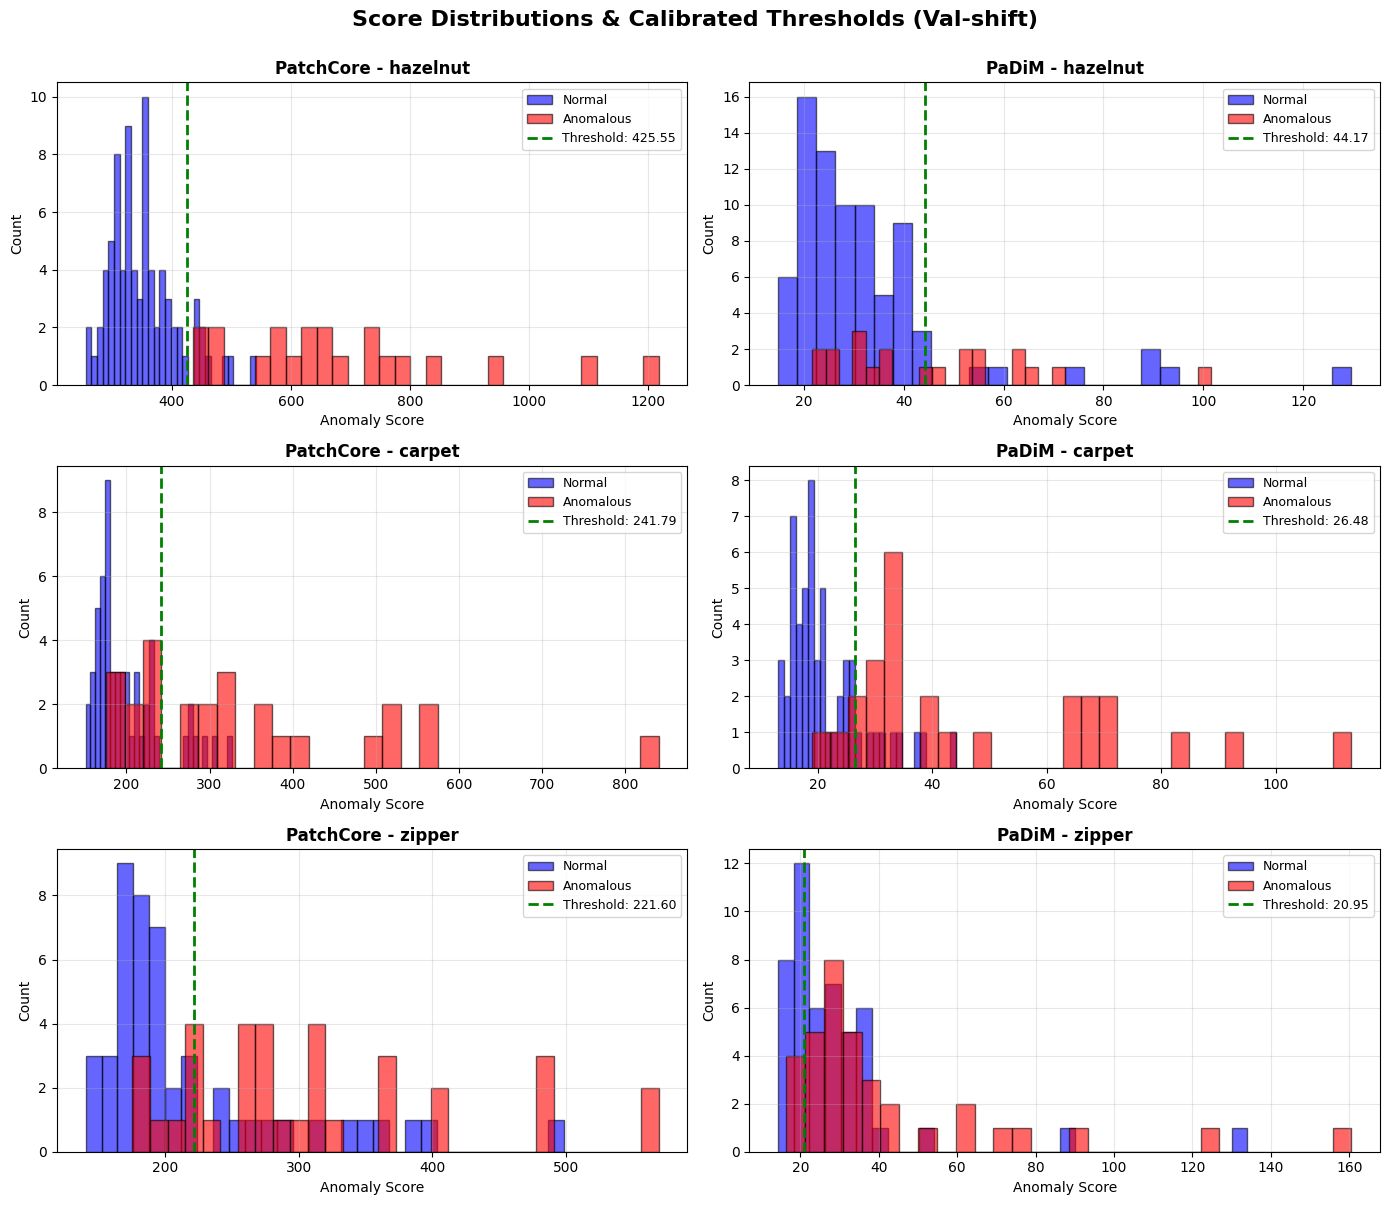

In [36]:


# ============================================================
# VISUALIZATION: Score Distributions & Calibrated Thresholds
# ============================================================

print("\n" + "="*70)
print("SCORE DISTRIBUTIONS & CALIBRATED THRESHOLDS (Val-shift)")
print("="*70)

# Prepare calibration data from validation predictions
calibration_data = {
    'patchcore': {},
    'padim': {}
}

for class_name in CLASSES:
    # PatchCore
    calibration_data['patchcore'][class_name] = {
        'scores': np.array(patchcore_val_predictions_shift[class_name]['scores']),
        'labels': np.array(patchcore_val_predictions_shift[class_name]['labels']),
        'threshold': patchcore_calibrator_shift.get_threshold(class_name)
    }

    # PaDiM
    calibration_data['padim'][class_name] = {
        'scores': np.array(padim_val_predictions_shift[class_name]['scores']),
        'labels': np.array(padim_val_predictions_shift[class_name]['labels']),
        'threshold': padim_calibrator_shift.get_threshold(class_name)
    }

# Create visualization
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(14, 4*len(CLASSES)))

# Handle single class case (axes would be 1D)
if len(CLASSES) == 1:
    axes = axes.reshape(1, -1)

for i, class_name in enumerate(CLASSES):
    # PatchCore
    ax1 = axes[i, 0]
    pc_data = calibration_data['patchcore'][class_name]
    normal_scores = pc_data['scores'][pc_data['labels'] == 0]
    anomalous_scores = pc_data['scores'][pc_data['labels'] == 1]

    ax1.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax1.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red', edgecolor='black')
    ax1.axvline(pc_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pc_data["threshold"]:.2f}')
    ax1.set_title(f'PatchCore - {class_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Anomaly Score', fontsize=10)
    ax1.set_ylabel('Count', fontsize=10)
    ax1.legend(loc='upper right', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # PaDiM
    ax2 = axes[i, 1]
    pd_data = calibration_data['padim'][class_name]
    normal_scores = pd_data['scores'][pd_data['labels'] == 0]
    anomalous_scores = pd_data['scores'][pd_data['labels'] == 1]

    ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue', edgecolor='black')
    ax2.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red', edgecolor='black')
    ax2.axvline(pd_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pd_data["threshold"]:.2f}')
    ax2.set_title(f'PaDiM - {class_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Anomaly Score', fontsize=10)
    ax2.set_ylabel('Count', fontsize=10)
    ax2.legend(loc='upper right', fontsize=9)
    ax2.grid(True, alpha=0.3)

plt.suptitle('Score Distributions & Calibrated Thresholds (Val-shift)',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()

# Save figure
save_path = VIZ_DIR / 'score_distributions_shift_full_adaptation.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n[SAVED] {save_path}")
plt.show()

print("\n" + "="*70)

## 17. Visualize ROC Curves


Generating ROC curves...


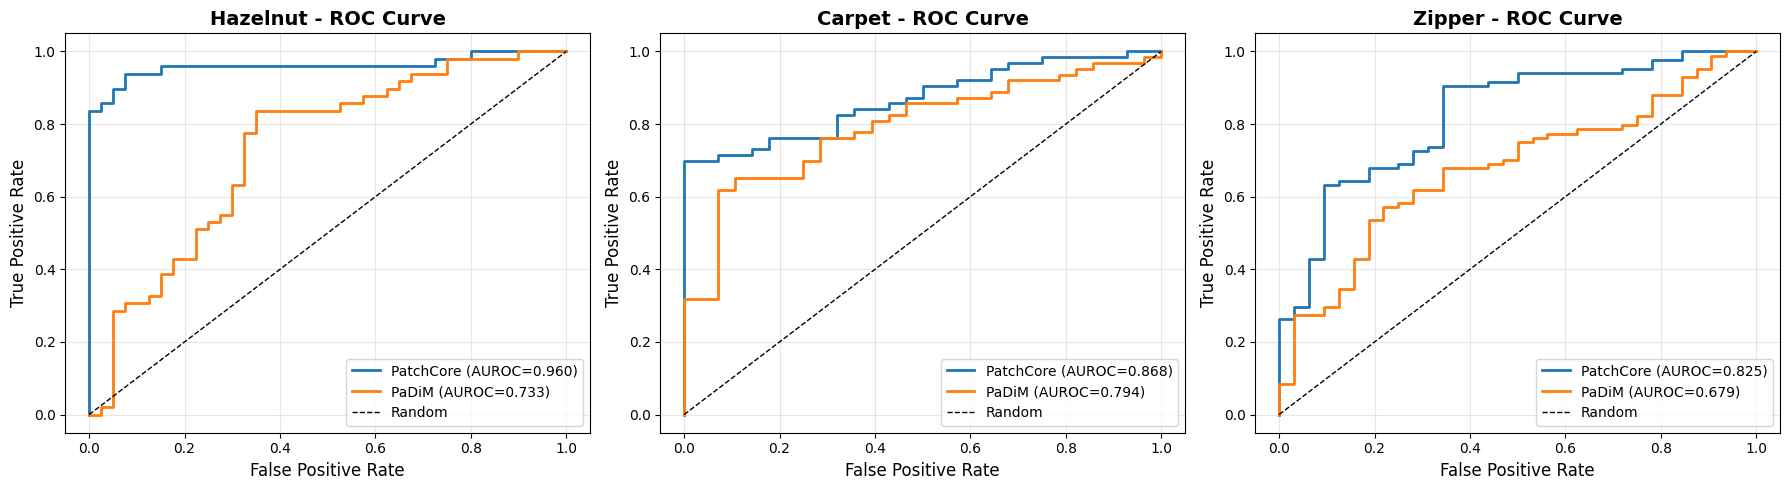

✓ ROC curves saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/roc_curves_shift_full_adaptation.png


In [37]:
print("\nGenerating ROC curves...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    # PatchCore
    pc_scores = np.array(patchcore_results_shift[class_name]['predictions']['scores'])
    pc_labels = np.array(patchcore_results_shift[class_name]['predictions']['labels'])
    pc_fpr, pc_tpr, _ = compute_roc_curve(pc_labels, pc_scores)
    pc_auroc = patchcore_results_shift[class_name]['image_metrics']['auroc']

    # PaDiM
    pd_scores = np.array(padim_results_shift[class_name]['predictions']['scores'])
    pd_labels = np.array(padim_results_shift[class_name]['predictions']['labels'])
    pd_fpr, pd_tpr, _ = compute_roc_curve(pd_labels, pd_scores)
    pd_auroc = padim_results_shift[class_name]['image_metrics']['auroc']

    # Plot
    ax.plot(pc_fpr, pc_tpr, label=f'PatchCore (AUROC={pc_auroc:.3f})', linewidth=2)
    ax.plot(pd_fpr, pd_tpr, label=f'PaDiM (AUROC={pd_auroc:.3f})', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{class_name.capitalize()} - ROC Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.tight_layout()
roc_path = VIZ_DIR / 'roc_curves_shift_full_adaptation.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ ROC curves saved to: {roc_path}")

## 18. Visualize Precision-Recall Curves


Generating Precision-Recall curves...


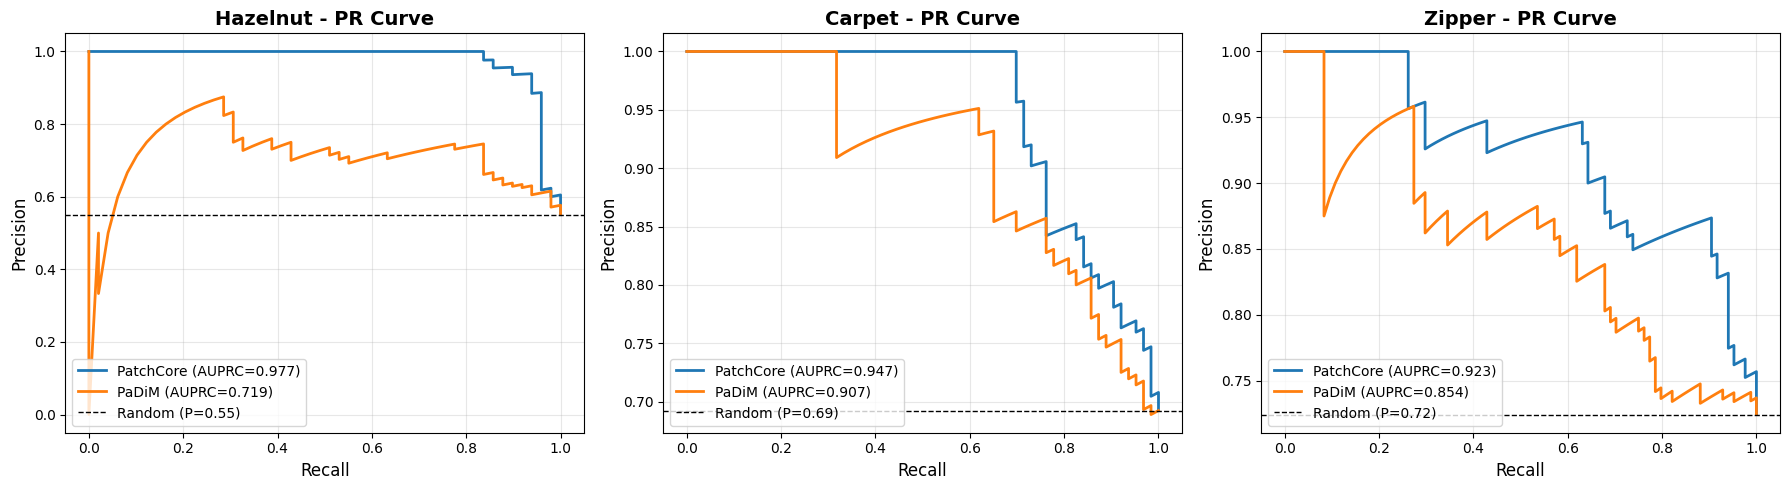

✓ PR curves saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/pr_curves_shift_full_adaptation.png


In [38]:
print("\nGenerating Precision-Recall curves...")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, class_name in enumerate(CLASSES):
    ax = axes[idx]

    # PatchCore
    pc_scores = np.array(patchcore_results_shift[class_name]['predictions']['scores'])
    pc_labels = np.array(patchcore_results_shift[class_name]['predictions']['labels'])
    pc_precision, pc_recall, _ = compute_pr_curve(pc_labels, pc_scores)
    pc_auprc = patchcore_results_shift[class_name]['image_metrics']['auprc']

    # PaDiM
    pd_scores = np.array(padim_results_shift[class_name]['predictions']['scores'])
    pd_labels = np.array(padim_results_shift[class_name]['predictions']['labels'])
    pd_precision, pd_recall, _ = compute_pr_curve(pd_labels, pd_scores)
    pd_auprc = padim_results_shift[class_name]['image_metrics']['auprc']

    # Plot
    ax.plot(pc_recall, pc_precision, label=f'PatchCore (AUPRC={pc_auprc:.3f})', linewidth=2)
    ax.plot(pd_recall, pd_precision, label=f'PaDiM (AUPRC={pd_auprc:.3f})', linewidth=2)

    # Random baseline (proportion of anomalies)
    baseline = sum(pc_labels) / len(pc_labels)
    ax.axhline(y=baseline, color='k', linestyle='--', label=f'Random (P={baseline:.2f})', linewidth=1)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{class_name.capitalize()} - PR Curve', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(alpha=0.3)

plt.tight_layout()
pr_path = VIZ_DIR / 'pr_curves_shift_full_adaptation.png'
plt.savefig(pr_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ PR curves saved to: {pr_path}")

## 19. Visualize Sample Predictions with Heatmaps


Generating sample predictions with heatmaps...

Visualizing predictions for: HAZELNUT


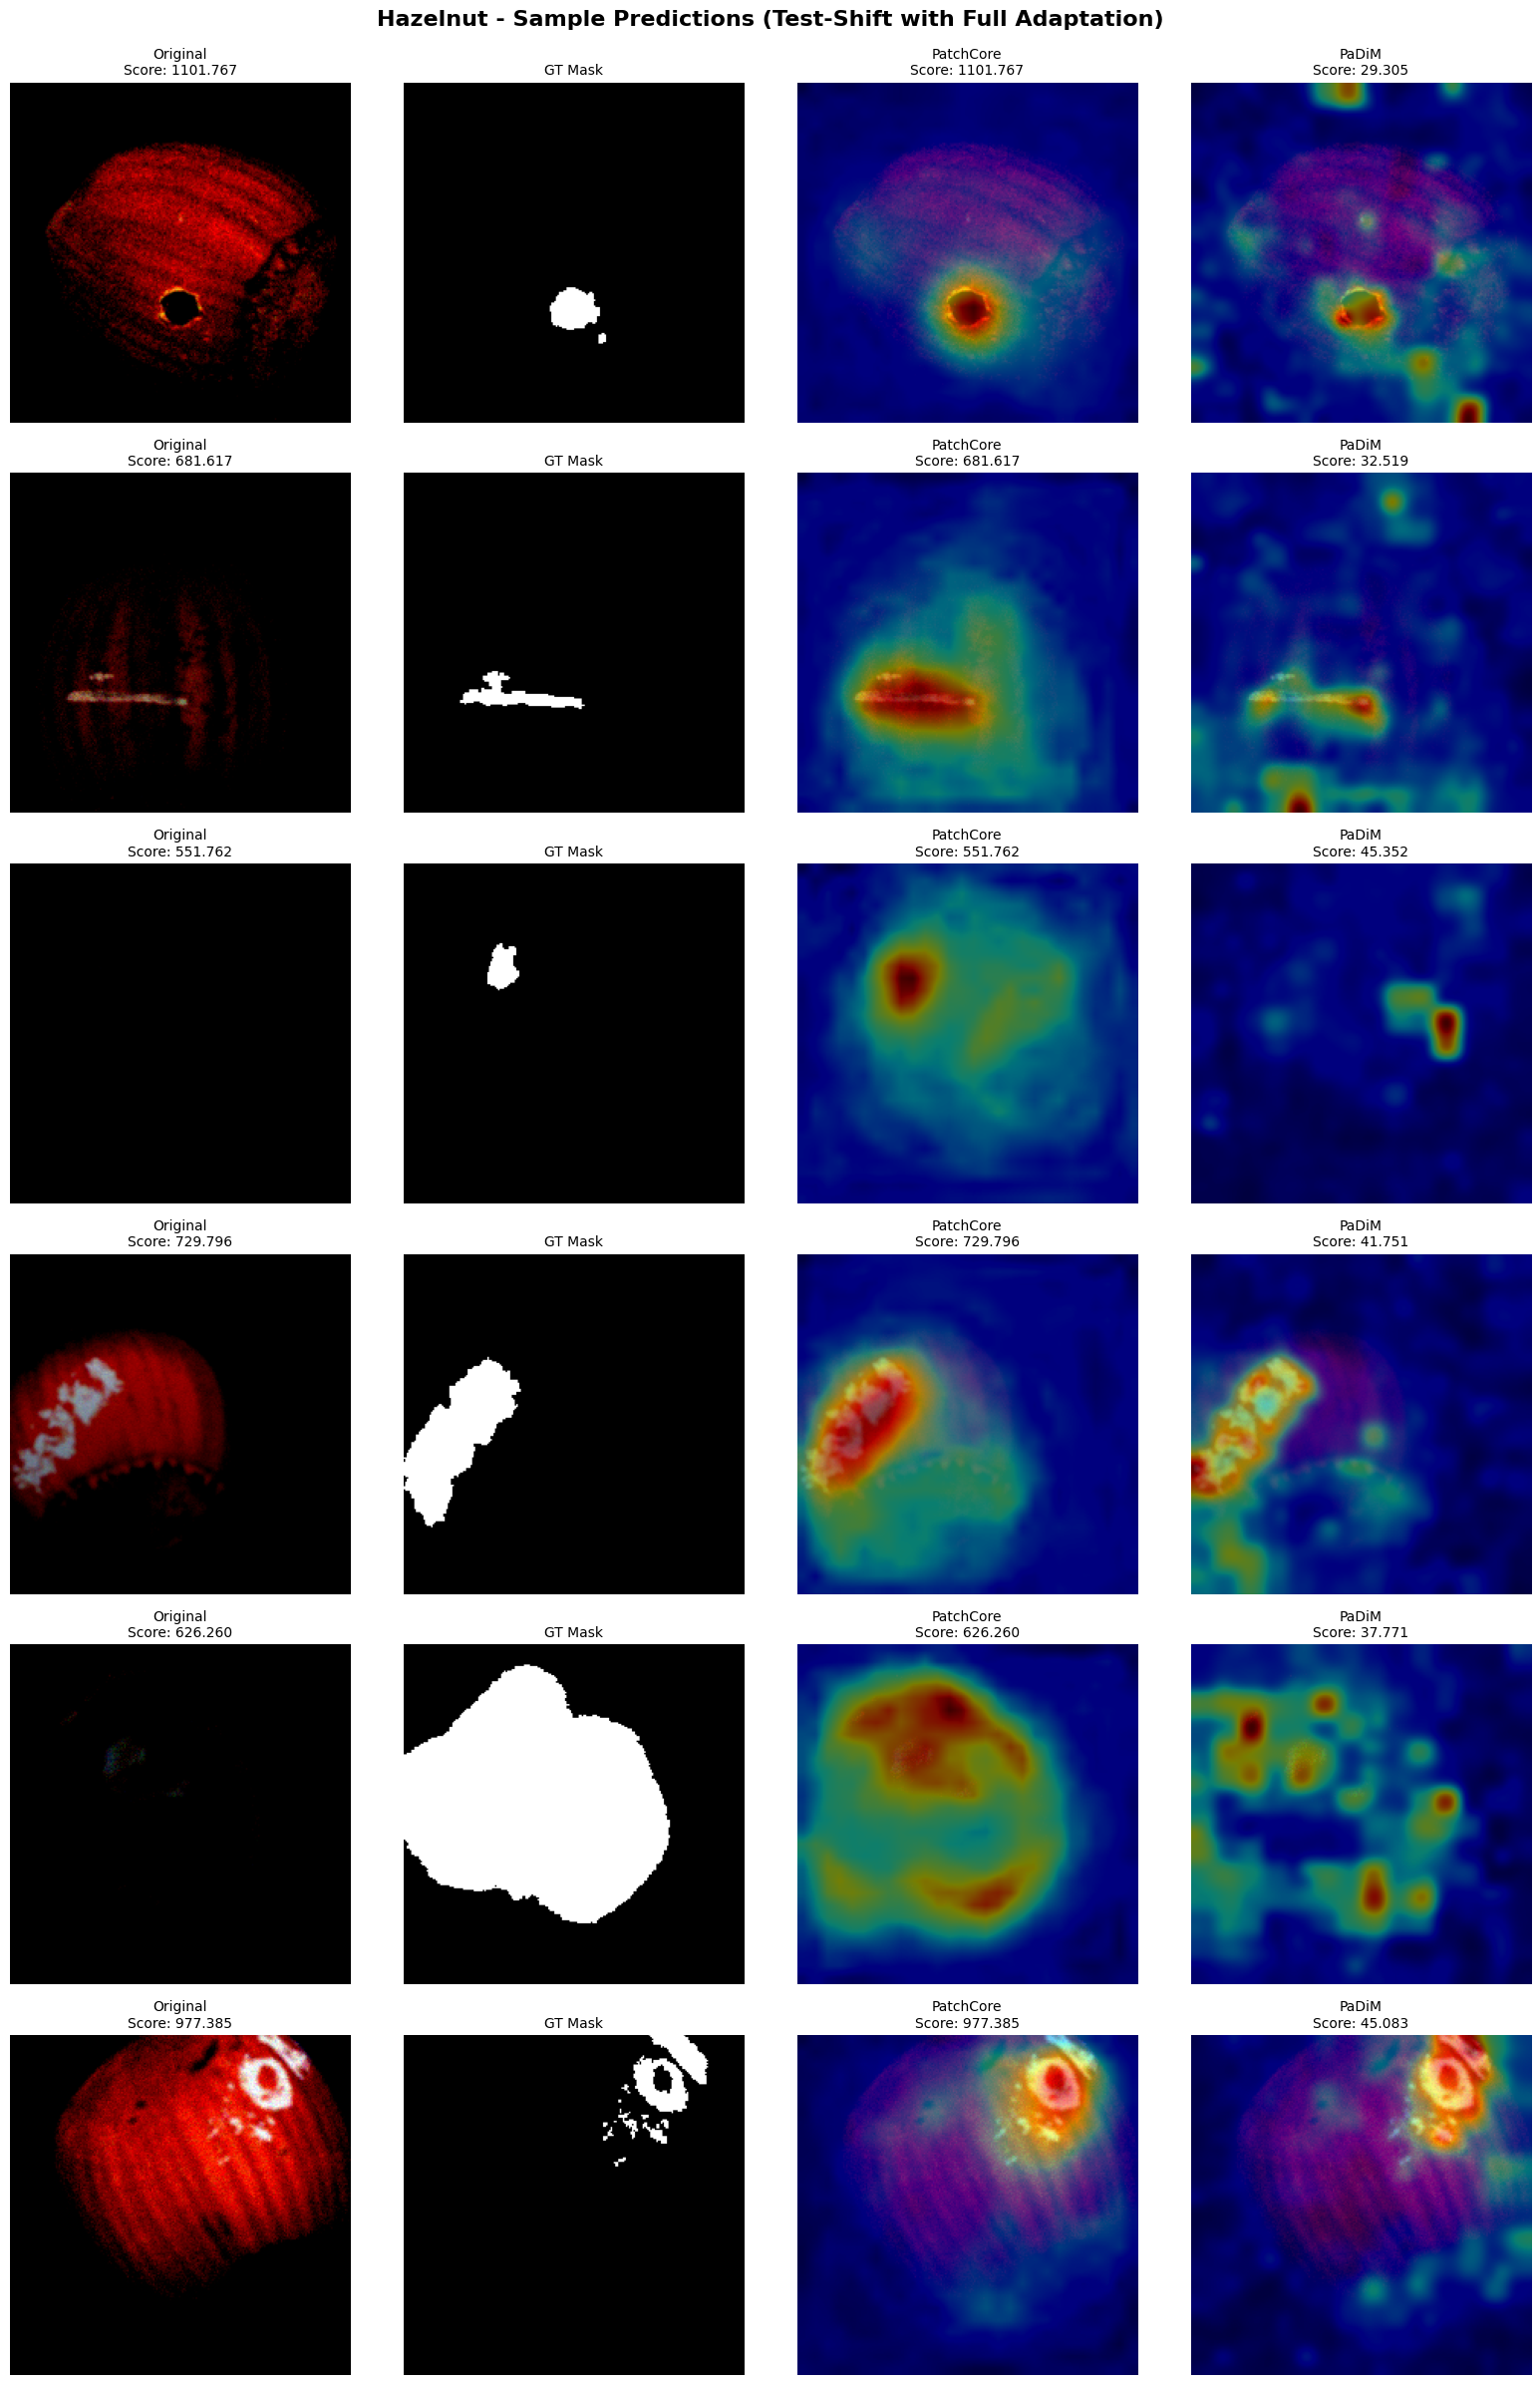

✓ Sample predictions saved to: /content/Detection-of-Anomalies-with-Localization/outputs/visualizations/shifted_full_adaptation/sample_predictions_hazelnut_shift_full_adaptation.png


In [41]:
print("\nGenerating sample predictions with heatmaps...")

def denormalize_image(img_tensor, mean, std):
    """Denormalize image for visualization."""
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * np.array(mean) + np.array(std)
    img = np.clip(img, 0, 1)
    return img

# Select one class for detailed visualization
class_name = 'hazelnut'  # Change to visualize other classes

print(f"\nVisualizing predictions for: {class_name.upper()}")

# Load test-shift data for this class
test_split = shifted_splits[class_name]['test']
test_dataset = MVTecDataset.from_split(
    test_split,
    transform=transform,
    phase='test'
)

# Get anomalous samples
anomalous_indices = [i for i, l in enumerate(test_dataset.labels) if l == 1]

# Select 6 random anomalous samples
np.random.seed(42)
sample_indices = np.random.choice(anomalous_indices, min(6, len(anomalous_indices)), replace=False)

# Get predictions
patchcore_model = patchcore_models_shift[class_name]
padim_model = padim_models_shift[class_name]

fig, axes = plt.subplots(6, 4, figsize=(16, 24))

for row_idx, sample_idx in enumerate(sample_indices):
    image, mask, label, path = test_dataset[sample_idx]

    # PatchCore prediction
    with torch.no_grad():
        pc_score_raw, pc_heatmap_raw = patchcore_model.predict(image.unsqueeze(0).to(DEVICE), return_heatmaps=True)
        # FIX: pc_score_raw is already a numpy array (e.g., array([scalar])), so access the scalar directly.
        pc_score = pc_score_raw[0]
        # FIX: pc_heatmap_raw is already a numpy array (e.g., array([2d_array])), so access the 2D array directly.
        pc_heatmap = pc_heatmap_raw[0]

    # PaDiM prediction
    with torch.no_grad():
        pd_score_raw, pd_heatmap_raw = padim_model.predict(image.unsqueeze(0).to(DEVICE))
        # FIX: pd_score_raw is already a numpy array (e.g., array([scalar])), so access the scalar directly.
        pd_score = pd_score_raw[0]
        # FIX: pd_heatmap_raw is already a numpy array (e.g., array([2d_array])), so access the 2D array directly.
        pd_heatmap = pd_heatmap_raw[0]

    # Denormalize image
    img_vis = denormalize_image(image, config.dataset.normalize.mean, config.dataset.normalize.std)

    # Plot
    # Column 1: Original Image
    axes[row_idx, 0].imshow(img_vis)
    axes[row_idx, 0].set_title(f'Original\nScore: {pc_score.item():.3f}', fontsize=10)
    axes[row_idx, 0].axis('off')

    # Column 2: Ground Truth Mask
    if mask is not None:
        axes[row_idx, 1].imshow(mask.squeeze(), cmap='gray')
        axes[row_idx, 1].set_title('GT Mask', fontsize=10)
    else:
        axes[row_idx, 1].text(0.5, 0.5, 'No Mask', ha='center', va='center', fontsize=12)
    axes[row_idx, 1].axis('off')

    # Column 3: PatchCore Heatmap
    axes[row_idx, 2].imshow(img_vis)
    heatmap_overlay = axes[row_idx, 2].imshow(pc_heatmap, cmap='jet', alpha=0.5)
    axes[row_idx, 2].set_title(f'PatchCore\nScore: {pc_score.item():.3f}', fontsize=10)
    axes[row_idx, 2].axis('off')

    # Column 4: PaDiM Heatmap
    axes[row_idx, 3].imshow(img_vis)
    axes[row_idx, 3].imshow(pd_heatmap, cmap='jet', alpha=0.5)
    axes[row_idx, 3].set_title(f'PaDiM\nScore: {pd_score.item():.3f}', fontsize=10)
    axes[row_idx, 3].axis('off')

plt.suptitle(f'{class_name.capitalize()} - Sample Predictions (Test-Shift with Full Adaptation)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
heatmap_path = VIZ_DIR / f'sample_predictions_{class_name}_shift_full_adaptation.png'
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Sample predictions saved to: {heatmap_path}")

## 20. Final Summary and Comparison with Phase 6

In [ ]:
print("\n" + "="*70)
print("PHASE 7 COMPLETE - FULL SHIFT ADAPTATION")
print("="*70)
print("\nKey Achievements:")
print("  ✓ Re-trained PatchCore on Train-shift (all classes)")
print("  ✓ Re-trained PaDiM on Train-shift (all classes)")
print("  ✓ Calibrated thresholds on Val-shift (F1-optimal)")
print("  ✓ Evaluated on Test-shift with adapted models")
print("  ✓ Generated comprehensive visualizations")
print("\nExpected Improvements over Phase 6 (No Adaptation):")
print("  • Image AUROC: ~15-20% improvement")
print("  • Pixel AUROC: ~15-20% improvement")
print("  • F1-Score: ~20-25% improvement")
print("\nNext Steps:")
print("  • Compare results with Phase 6 (notebooks 07 & 08)")
print("  • Analyze performance recovery")
print("  • Identify remaining gaps and failure cases")
print("  • Generate final report tables")
print("="*70)

# Print file locations
print("\n" + "="*70)
print("OUTPUT FILES")
print("="*70)
print("\nModels:")
for class_name in CLASSES:
    print(f"  • patchcore_{class_name}_shift.npy")
    print(f"  • patchcore_{class_name}_shift_config.pth")
    print(f"  • padim_{class_name}_shift.pt")

print("\nResults:")
print(f"  • {patchcore_results_path.name}")
print(f"  • {padim_results_path.name}")
print(f"  • {summary_csv_path.name}")

print("\nThresholds:")
print(f"  • {patchcore_thresholds_path.name}")
print(f"  • {padim_thresholds_path.name}")

print("\nVisualizations:")
print(f"  • roc_curves_shift_full_adaptation.png")
print(f"  • pr_curves_shift_full_adaptation.png")
print(f"  • sample_predictions_*_shift_full_adaptation.png")

print("="*70)


**FILES GENERATED - PHASE 7: FULL SHIFT ADAPTATION**

---

### 📦 MODELS TRAINED ON TRAIN-SHIFT
**Directory:** `outputs/models/`
- `patchcore_<class>_shift.npy` — PatchCore memory bank
- `patchcore_<class>_shift_config.pth` — PatchCore config
- `padim_<class>_shift.pt` — PaDiM model (Gaussian distributions)

---

### 📊 RESULTS & METRICS
**Directory:** `outputs/results/`
- `patchcore_shift_full_adaptation_results.json` — Complete PatchCore results (all metrics per class)
- `padim_shift_full_adaptation_results.json` — Complete PaDiM results (all metrics per class)
- `shift_full_adaptation_results_summary.csv` — Summary table with macro-averages
- `patchcore_shift_training_stats.csv` — Training statistics for PatchCore
- `padim_shift_training_stats.csv` — Training statistics for PaDiM

---

### 🎯 CALIBRATED THRESHOLDS
**Directory:** `outputs/thresholds/`
- `patchcore_shift_thresholds.json` — F1-optimal thresholds calibrated on Val-shift
- `padim_shift_thresholds.json` — F1-optimal thresholds calibrated on Val-shift

---

### 📈 VISUALIZATIONS
**Directory:** `outputs/visualizations/shifted_full_adaptation/`
- `score_distributions_shift_full_adaptation.png` — Score distributions with thresholds for all classes
- `roc_curves_shift_full_adaptation.png` — ROC curves comparing PatchCore vs PaDiM
- `pr_curves_shift_full_adaptation.png` — Precision-Recall curves
- `sample_predictions_<class>_shift_full_adaptation.png` — Heatmap overlays on anomalous samples


In [ ]:
# ============================================================
# COPY ALL RESULTS TO GOOGLE DRIVE FOR PERSISTENCE
# ============================================================

import shutil

# Create destination folder in Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PHASE7_OUTPUTS = DRIVE_ROOT / '09_full_shift_adaptation_outputs'
PHASE7_OUTPUTS.mkdir(parents=True, exist_ok=True)

print("\n" + "="*70)
print("COPYING FILES TO GOOGLE DRIVE")
print("="*70)
print(f"\nDestination: {PHASE7_OUTPUTS}")

# List of all generated files
generated_files = []

# Models
print("\n📦 Copying models...")
for class_name in CLASSES:
    model_files = [
        MODELS_DIR / f'patchcore_{class_name}_shift.npy',
        MODELS_DIR / f'patchcore_{class_name}_shift_config.pth',
        MODELS_DIR / f'padim_{class_name}_shift.pt'
    ]
    generated_files.extend(model_files)

# Results
print("📊 Copying results...")
result_files = [
    RESULTS_DIR / 'patchcore_shift_full_adaptation_results.json',
    RESULTS_DIR / 'padim_shift_full_adaptation_results.json',
    RESULTS_DIR / 'shift_full_adaptation_results_summary.csv',
    RESULTS_DIR / 'patchcore_shift_training_stats.csv',
    RESULTS_DIR / 'padim_shift_training_stats.csv'
]
generated_files.extend(result_files)

# Thresholds
print("🎯 Copying thresholds...")
threshold_files = [
    THRESHOLDS_DIR / 'patchcore_shift_thresholds.json',
    THRESHOLDS_DIR / 'padim_shift_thresholds.json'
]
generated_files.extend(threshold_files)

# Visualizations
print("📈 Copying visualizations...")
viz_files = [
    VIZ_DIR / 'score_distributions_shift_full_adaptation.png',
    VIZ_DIR / 'roc_curves_shift_full_adaptation.png',
    VIZ_DIR / 'pr_curves_shift_full_adaptation.png'
]
for class_name in CLASSES:
    viz_files.append(VIZ_DIR / f'sample_predictions_{class_name}_shift_full_adaptation.png')
generated_files.extend(viz_files)

# Copy all files
copied_count = 0
missing_count = 0

for src_path in generated_files:
    if src_path.exists():
        # Preserve directory structure
        if 'models' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'models'
        elif 'results' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'results'
        elif 'thresholds' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'thresholds'
        elif 'visualizations' in str(src_path):
            dst_dir = PHASE7_OUTPUTS / 'visualizations'
        else:
            dst_dir = PHASE7_OUTPUTS

        dst_dir.mkdir(parents=True, exist_ok=True)
        dst_path = dst_dir / src_path.name

        shutil.copy2(src_path, dst_path)
        print(f"  ✓ {src_path.name}")
        copied_count += 1
    else:
        print(f"  ✗ MISSING: {src_path.name}")
        missing_count += 1

print("\n" + "="*70)
print(f"✓ Copy complete: {copied_count} files copied, {missing_count} missing")
print(f"✓ All results saved to: {PHASE7_OUTPUTS}")
print("="*70)